# Deep Learning Basics with PyTorch
## Part II — Neural Networks and PyTorch Basics
## Chapter 8 — Organizing Code with torch.nn

In [1]:
# Core libraries for tensors, arrays, and plotting
import torch  # tensors and autograd
import numpy as np  # numerical arrays
import matplotlib.pyplot as plt  # plotting
from torch import nn  # neural network layers
plt.style.use('seaborn-v0_8')  # consistent plot style
from sklearn.datasets import make_moons  # toy dataset
from sklearn.model_selection import train_test_split  # splits
%config InlineBackend.figure_format = 'retina'  # crisp inline images

## Define model and training helpers

In [2]:
class TinyMLP(nn.Module):  # tiny 2->hidden->2 MLP module
    def __init__(self, in_dim=2, hidden=16, out_dim=2):  # configure layer sizes
        super().__init__()  # initialize base nn.Module
        self.net = nn.Sequential(  # stack layers in order
            nn.Linear(in_dim, hidden),  # affine: (in_dim -> hidden)
            nn.ReLU(),  # nonlinearity
            nn.Linear(hidden, out_dim),  # affine: (hidden -> out_dim), returns logits
        )

    def forward(self, x):  # x: (batch, in_dim) input features
        return self.net(x)  # logits: (batch, out_dim)

# Prepare data (moons)
X, y = make_moons(n_samples=600, noise=0.25, random_state=0)  # toy 2D dataset
X_tr, X_te, y_tr, y_te = train_test_split(  # stratified train/test split
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_tr = torch.tensor(X_tr, dtype=torch.float32)  # training features tensor
X_te = torch.tensor(X_te, dtype=torch.float32)  # test features tensor
y_tr = torch.tensor(y_tr, dtype=torch.long)  # training labels (class indices)
y_te = torch.tensor(y_te, dtype=torch.long)  # test labels (class indices)

# Model, optimizer, loss
model = TinyMLP()  # instantiate classifier
opt = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer
loss_fn = nn.CrossEntropyLoss()  # multi-class classification loss

def accuracy(logits, y):  # compute classification accuracy
    return (logits.argmax(1) == y).float().mean().item()  # fraction correct

## Train and evaluate

In [3]:
losses = []
acc_history = []
for _ in range(50):
    model.train()
    logits = model(X_tr)  # raw model scores before softmax/sigmoid
    loss = loss_fn(logits, y_tr)  # training objective
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(float(loss.detach()))

    model.eval()
    with torch.no_grad():
        acc = accuracy(model(X_te), y_te)
    acc_history.append(acc)

losses[-1], acc_history[-1]

(0.28633546829223633, 0.8933333158493042)

## Decision boundary (trained MLP)

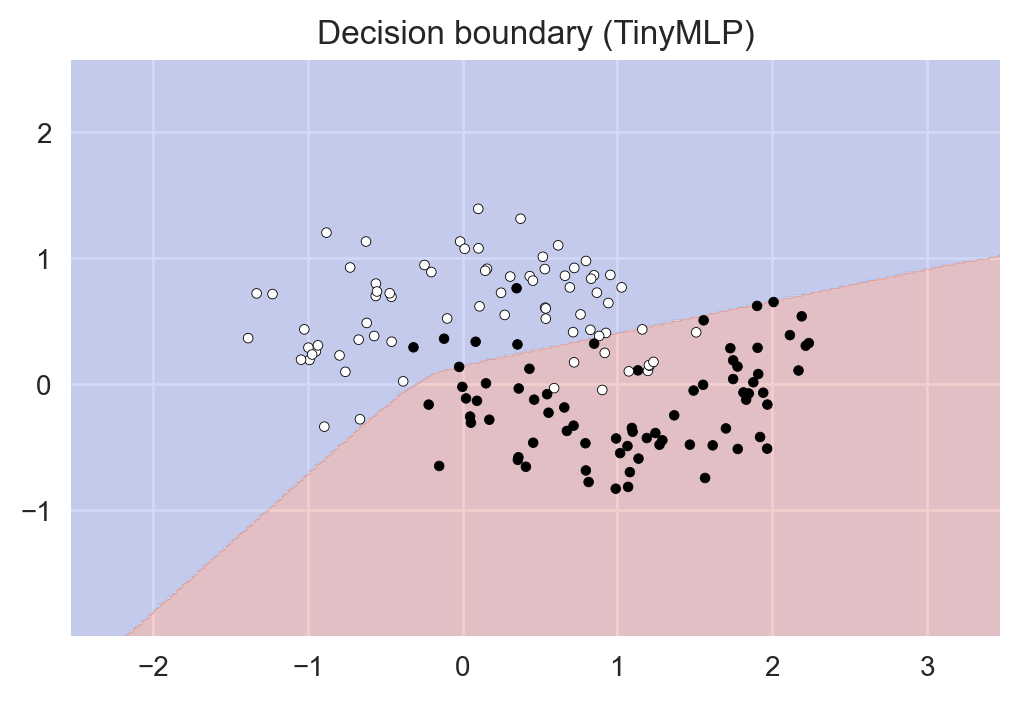

In [4]:
import numpy as np, matplotlib.pyplot as plt  # NumPy for grid; Matplotlib for plotting
# Concatenate train and test to get plotting ranges
allX = torch.cat([X_tr, X_te], dim=0).numpy()  # (N, 2) array for min/max
# Build a dense grid over feature space
xx, yy = np.meshgrid(  # coordinate matrices for contour plot
    np.linspace(allX[:,0].min()-1, allX[:,0].max()+1, 300),  # x range
    np.linspace(allX[:,1].min()-1, allX[:,1].max()+1, 300)  # y range
)
# Stack grid coordinates into a (M, 2) tensor
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)  # evaluation points
model.eval()  # switch to eval mode (no dropout/batchnorm effects)
with torch.no_grad():  # disable gradient tracking for inference
    zz = model(grid).argmax(1).reshape(xx.shape).numpy()  # class index per grid point
# Plot decision regions and test points
plt.figure(figsize=(5.2, 3.6))  # width x height in inches
plt.contourf(xx, yy, zz, alpha=0.25, cmap='coolwarm')  # filled contour of classes
plt.scatter(X_te[:,0], X_te[:,1], c=y_te, s=12, edgecolor='k')  # test points overlay
plt.title('Decision boundary (TinyMLP)')  # figure title
plt.tight_layout(); plt.show()  # tidy layout and render

## Training curve (loss and accuracy)

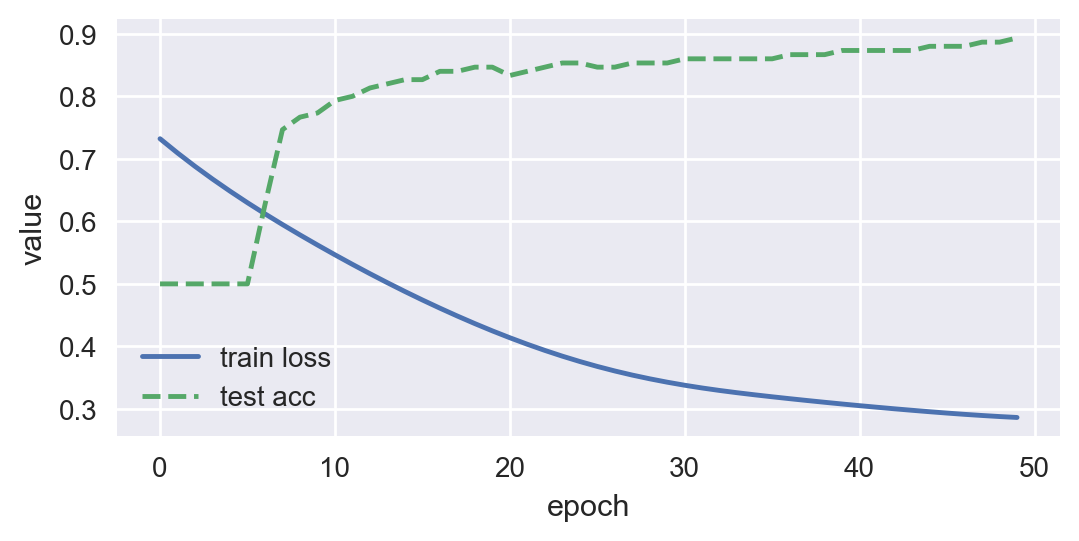

In [5]:
plt.figure(figsize=(5.5, 2.8))  # set compact figure size
plt.plot(losses, label='train loss')  # line plot of training loss per epoch
plt.plot(acc_history, label='test acc', linestyle='--')  # dashed accuracy curve
plt.xlabel('epoch'); plt.ylabel('value')  # axis labels
plt.legend(frameon=False)  # simple legend without frame
plt.tight_layout(); plt.show()  # tighten layout and render